In [5]:
#DecisionTreeClassifier, KNeighborsClassifier, RandomForestClassifier, LogisticRegression, GradientBoostingClassifier
#5개를 같이 학습해서 predict_proba로 각각 학습한 값의 평균이 0.5가 넘을 때 1(투표 한걸로)로 보도록 학습시켰지만
#실수로 해당 파일의 데이터를 experiment파일에 데이터를 합치고 힙친 파일의 데이터로 덮어 씌어 데이터가 남아 있지 않음.

In [11]:
#무응답도 데이터 로서 가치가 있다고 생각하여 시간 데이터 왜에는 전처리 하지 않았었음.
#시간 데이터 전처리 값 할 시 500단위로 구분하거나 임의로 내가 직접 값을 구분하여(ex: 500, 1000, 3000, 5000, 8000...) 
#전처리 하였을 때는 학습이 정상 적으로 되지 않는 다고 생각했다.
#(이 당시에는 train, test파일 만을 그대로 이용해 정확도와 같은 값들을 정상적으로 구할 수 없었기에 이 판단이 맞는지는 확신이 없다)
#학습 또한 train 데이터의 index를 test와 동일 하게 하여 학습 했었다.

In [13]:
#K_fold 기반의 스태킹 앙상블도 해보았지만 해당 방법으로는 y_test 값이 없어 
#더 이상 진행이 불가능 학습이 불가능 하다 생각하여 회의 전까지 이 이상 진행하지 못했다.

In [14]:
#위의 방법으로 진행 했기에 오류가 발생 하였지만 predict_proba로 예측한 값의 임계값을 수차례 수정하며 train의 voted값의 1과 0의 비율과
#예측된 값의 1과 0의 비율 맞추려고 했었다.
#GridSearchCV를 이용해 최적의 파라미터를 구하려 했으로 위와 같은 이유로(y_test값이 없음) 
#이는 정상 적인 값이 아니라고 생학하여 진행을 중지 하였다.

In [15]:
#get_clf_eval함수도 작성 하였으로 마찬가지의 이유로 진행을 하지 못했음.

# 인공지능적사고와문제해결 프로젝트2 8조

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import lightgbm

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [2]:
# set options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
# 예측한 값으로 성능을 평가하는 함수
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred) # 오차 행렬
    accuracy = accuracy_score(y_test, pred) # 정확도
    precision = precision_score(y_test, pred) # 정밀도
    recall = recall_score(y_test, pred) # 재현율
    f1 = f1_score(y_test, pred) # F1
    roc_auc = roc_auc_score(y_test, pred_proba) # ROC-AUC
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

## 데이터 전처리

In [4]:
vote_df = pd.read_csv("C:\\Users\kimsj\\OneDrive\\바탕 화면\\대학교\\git\\AI-project\\data\\train.csv", encoding="utf-8")
test_df = pd.read_csv("C:\\Users\kimsj\\OneDrive\\바탕 화면\\대학교\\git\\AI-project\\data\\test.csv", encoding="utf-8")
print("dataset shape: ", vote_df.shape)
print("dataset shape: ", test_df.shape)

# 인덱스 제거
vote_df.drop("index", axis=1, inplace=True)
test_index = test_df["index"]
test_df.drop("index", axis=1, inplace=True)

dataset shape:  (36425, 78)
dataset shape:  (9107, 77)


In [5]:
# 0값을 검사할 피처명 리스트 객체 설정
# zero_features = ['education', 'engnat', 'hand', 'urban']
# education 비율 맞추기?
zero_features = []

# tp 추가
for i in range(1, 11):
    s = 'tp' + chr(48+(i//10)) + chr(48+(i%10))
    zero_features.append(s)
    
# zero_features 리스트 내부에 저장된 개별 피처들에 대해 0값을 평균 값으로 대체
vote_df[zero_features] = vote_df[zero_features].replace(0, vote_df[zero_features].mean())
test_df[zero_features] = test_df[zero_features].replace(0, test_df[zero_features].mean())

### 인코딩

레이블 인코딩 vote_df와 test_df의 age_group 컬럼을 레이블 인코딩 했다.

In [6]:
# 레이블 인코딩
encoder = LabelEncoder()
encoder_test = LabelEncoder()

encoder.fit(vote_df['age_group'])
encoder_test.fit(test_df['age_group'])
labels = encoder.transform(vote_df['age_group'])
labels_test = encoder_test.transform(test_df['age_group'])

vote_df['age_group'] = labels
test_df['age_group'] = labels_test

def get_categoty_age(age_num):
    num = age_num;
    if age_num == 0: num =7

    return num

vote_df["age_group"] = vote_df["age_group"].apply(lambda x : get_categoty_age(x))
test_df["age_group"] = test_df["age_group"].apply(lambda x : get_categoty_age(x))

# 원핫 인코딩
def dummy_data(data, columns) :
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data

dummy_columns = ['engnat', 'gender','hand', 'married', 'race', 'religion', 'urban']
# wr 추가
for i in range(1, 14):
    s = 'wr_' + chr(48+(i//10)) + chr(48+(i%10))
    dummy_columns.append(s)
# wf 추가
for i in range(1, 4):
    s = 'wf_' + chr(48+(i//10)) + chr(48+(i%10))
    dummy_columns.append(s)
# print(dummy_columns)

vote_df = dummy_data(vote_df, dummy_columns)
test_df = dummy_data(test_df, dummy_columns)


### 이상값 처리

In [16]:
#시간 데이터를 1000 단위로 구분해 전처리 하였고, 
#9를 넘는 값은 이상치 데이터로 보고 제거 해주었다. 
#9를 넘는 데이터가 아니라 7,8,10,11,12,13 각각을 이상치로 보고 제거 했을 경우에는 
#9를 넘는 값을 이상치 데이터로 본것보다 F1값이 낮게 나왔다.
#시간 데이터을 value_counts() 하여 값들의 분포도를 확인 했을 때는 8 이상인 값을 제거하는 것이 맞다고 생각 했었다. 

In [7]:
# 시간 데이터 전처리

#Q_E 시간
Q_E = []
for i in range(97, 117):
    a = 'Q' + chr(i) + 'E'
    Q_E.append(a)

def get_categoty_time(Q_time):
    cat = 0
    if Q_time <= 1000 : cat = 1
    elif Q_time <= 2000 : cat = 2
    elif Q_time <= 3000 : cat = 3
    elif Q_time <= 4000 : cat = 4
    elif Q_time <= 5000 : cat = 5
    elif Q_time <= 6000 : cat = 6
    elif Q_time <= 7000 : cat = 7
    elif Q_time <= 8000 : cat = 8
    elif Q_time <= 9000 : cat = 9
    elif Q_time <=10000 : cat = 10
    elif Q_time <=15000 : cat = 11
    elif Q_time <=20000 : cat = 12
    else : cat = 13

    return cat

for Q_time in Q_E:
    vote_df[Q_time] = vote_df[Q_time].apply(lambda x : get_categoty_time(x))
    test_df[Q_time] = test_df[Q_time].apply(lambda x : get_categoty_time(x))


In [8]:
# 시간 이상치 데이터 제거
def get_outlier2(df=None, column=None):
    fraud = df[column]
    
    outlier_index = fraud[fraud > 9].index    
    return outlier_index
for Q_time in Q_E:
    outlier_index2 = get_outlier2(df=vote_df, column=Q_time)
    vote_df.drop(outlier_index2, axis=0, inplace=True)


## 모델 학습

In [18]:
#데이터 들을 undersampling 하거나 oversampling을 하거나 smote oversampling을 각각 해보며 여러 테스트를 진행해 보았다.

In [9]:
# label/feature 분리 및 학습세트/평가세트 분리
y_labels = vote_df.loc[:,'voted']
X_features = vote_df.drop('voted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=156)

# 분포 비율 확인
train_cnt = y_train.count()
test_cnt = y_test.count()

print("학습 세트 Shape:{0}, 테스트 세트 Shape:{1}".format(X_train.shape, X_test.shape))
print(" 학습 세트 레이블 값 분포 비율")
print(y_train.value_counts()/train_cnt)
print("\n 테스트 세트 레이블 값 분포 비율")
print(y_test.value_counts()/test_cnt)
print()

# 데이터 정규화(스케일링)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

test_sc = scaler.transform(test_df) # test data scaling

#undersampling
under_sampler = RandomUnderSampler(random_state=156)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)

# # smote oversampling
# smote = SMOTE(random_state=156)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# 학습
evals = [(X_test, y_test)]
xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
xgb_model.fit(X_train_under, y_train_under, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
preds = xgb_model.predict(X_test)
pred_proba = xgb_model.predict_proba(X_test)[:,1]

get_clf_eval(y_test, preds, pred_proba)

학습 세트 Shape:(25362, 121), 테스트 세트 Shape:(6341, 121)
 학습 세트 레이블 값 분포 비율
0    0.550587
1    0.449413
Name: voted, dtype: float64

 테스트 세트 레이블 값 분포 비율
0    0.529885
1    0.470115
Name: voted, dtype: float64

[0]	validation_0-logloss:0.67448
[1]	validation_0-logloss:0.65930


C:\Users\kimsj\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[2]	validation_0-logloss:0.64708
[3]	validation_0-logloss:0.63647
[4]	validation_0-logloss:0.62782
[5]	validation_0-logloss:0.62051
[6]	validation_0-logloss:0.61430
[7]	validation_0-logloss:0.60911
[8]	validation_0-logloss:0.60487
[9]	validation_0-logloss:0.60081
[10]	validation_0-logloss:0.59745
[11]	validation_0-logloss:0.59469
[12]	validation_0-logloss:0.59235
[13]	validation_0-logloss:0.59020
[14]	validation_0-logloss:0.58834
[15]	validation_0-logloss:0.58665
[16]	validation_0-logloss:0.58485
[17]	validation_0-logloss:0.58378
[18]	validation_0-logloss:0.58241
[19]	validation_0-logloss:0.58118
[20]	validation_0-logloss:0.58018
[21]	validation_0-logloss:0.57922
[22]	validation_0-logloss:0.57860
[23]	validation_0-logloss:0.57781
[24]	validation_0-logloss:0.57741
[25]	validation_0-logloss:0.57685
[26]	validation_0-logloss:0.57636
[27]	validation_0-logloss:0.57610
[28]	validation_0-logloss:0.57570
[29]	validation_0-logloss:0.57532
[30]	validation_0-logloss:0.57519
[31]	validation_0-logl

C:\Users\kimsj\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


### 테스트 데이터 예측1

In [6]:
#학습한 데이터로 test_sc를 이용해 데이터 예측을 진행 했는데 샘플링의 유무, 스케일링의 유무, 를 비교하여 실행해도 오류가 발생하였다.
#학습한 데이터의 index가 test_sc or test_df와 다른것이 원인 으로 생각해 학습하는 데이터의 index를 test_df와 동일 하게 하고 
#위와 마찬가지로 샘플링의 유무와 같은 것들을 바꾸며 실행 하여도, 오류가 조금 씩 발생 하였다.

In [ ]:
xgb_model_test = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
for i in range(1):
    xgb_model_test.fit(X_features.sample(test_df.shape[0]), y_labels.sample(test_df.shape[0]), eval_metric="logloss")
# 데이터 정규화(스케일링)
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)

test_sc = scaler.transform(test_df) # test data scaling

# preds_test = xgb_model.predict(test_df)
# pred_proba_test = xgb_model.predict_proba(test_df)[:,1]
preds_test = xgb_model_test.predict(test_sc)
pred_proba_test = xgb_model_test.predict_proba(test_sc)[:,1]

test_submission = pd.DataFrame({"index" : test_index,
                                "pred_prob" : pred_proba_test,
                                "pred" : preds_test})

### 테스트 데이터 예측2

In [7]:
#학습을 test_df와 index가 같게 하여 학습을 한 후 예측을 진행할 경우 예측 값에 버그가 발생하지 않는 것을 확인 후  
#여러번 실행해 값을 확인한 결과 값의 변동률이 싱한 것을 확인
# for문으로 수차례 학습하고 예측하기를 반복 후 해당 예측 값들을 평균을 내었다.
#평균 값을 넘으면 pred를 1로 아니면 0으로 값을 설정 하였다.
#(평균으로 한 이유는 0.5나 기타 다른 값으로 할 경우 랜덤한 평균 값이 나오는 예측 결과 값을 통제 할 수 없었기 때문이다.)

In [14]:
xgb_model_test = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3, objective="binary:logistic", random_state=156)
pred_proba
num = 150
for i in range(num):
    xgb_model_test.fit(X_features.sample(9107), y_labels.sample(9107))
    pred_proba = xgb_model_test.predict_proba(test_sc)[:,1]
    
pred_proba_test = pred_proba/num
preds_test =1
test_submission = pd.DataFrame({"index" : test_index,
                                "pred_prob" : pred_proba_test,
                                "pred" : preds_test})

C:\Users\kimsj\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:05:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\kimsj\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[23:05:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:05:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:05:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:05:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:06:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:06:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:07:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:07:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:08:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:11:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:11:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:13:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:15:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [15]:
#평균 값 구한 후 pred 값을 1 or 0으로 설정하는 부분
num1 = 0;

for i in range(test_submission.shape[0]):
        num1 += test_submission['pred_prob'][i]
print(num1/test_submission.shape[0])

num2 = 0;

for i in range(test_submission.shape[0]):
    if (test_submission['pred_prob'][i]) > (num1/test_submission.shape[0]):
        num2 +=1
        test_submission['pred'][i] = 1
    else: test_submission['pred'][i] = 0
print(num2)

0.0044945132307957995


<ipython-input-15-e63885d77495>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  else: test_submission['pred'][i] = 0
<ipython-input-15-e63885d77495>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_submission['pred'][i] = 1


4583


In [16]:
test_submission.to_csv("C:\\Users\kimsj\\OneDrive\\바탕 화면\\대학교\\git\\AI-project\\experiment\\test_submission.csv", index = False)

In [17]:
# 결과 확인
test_result_df = pd.read_csv("C:\\Users\kimsj\\OneDrive\\바탕 화면\\대학교\\git\\AI-project\\experiment\\test_submission.csv", encoding="utf-8")
test_result_df.head(10)

,index,pred_prob,pred
0,38741,0.004250,0
1,43904,0.004114,0
2,41036,0.004449,0
3,6939,0.004717,1
4,14682,0.004485,0
5,35469,0.004502,1
6,33948,0.004435,0
7,3082,0.004782,1
8,33291,0.004450,0
9,32694,0.004171,0


### feature selection

In [19]:
#feature selection 어느 순간 f(숫자) 값으로 결과가 나왔고, 이 문제를 xgb_mobel의 학습 방법들을 변경하며 같이 값을 확인 했을 떄
# f(숫자)가 아니라 정상적으로 나오는 경우도 있었으나 현재의 방법을 사용 중인 상황(변경은 거의 불가능)에서 해결 방법은 찾지 못했음.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

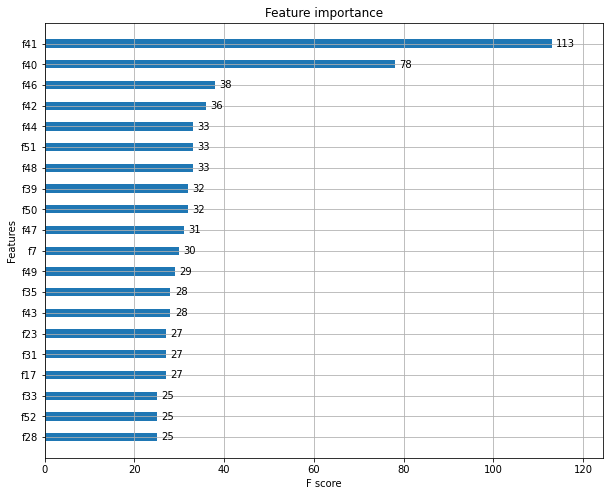

In [18]:
from xgboost import plot_importance
fig, ax = plt.subplots(1,1, figsize=(10,8))
plot_importance(xgb_model, ax=ax, max_num_features=20, height=0.4)

In [9]:
#feature selection으로 높게 나온 컬럼 들을 선별해 학습하고, pred 값을 예측하기 위해 LGBM을 사용했다(XGBoost는 오류가 있었다.)

In [ ]:
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=400)
evals = [(X_test, y_test)]
lgbm.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
lgbm_preds = lgbm.predict(X_test)
lgbm_pred_proba = lgbm.predict_proba(X_test)[:,1]


get_clf_eval(y_test, lgbm_preds, lgbm_pred_proba)

In [ ]:
selected = (lgbm.feature_importances_ > 30)
index_for_selection =np.array(range(len(selected)))
selected_column_index = index_for_selection[selected]

X_train_selected = pd.DataFrame(X_train).iloc[:,selected_column_index]
x_test_selected = pd.DataFrame(X_test).iloc[:,selected_column_index]

In [ ]:
lgbm = LGBMClassifier(n_estimators=400)
evals = [(x_test_selected, y_test)]
lgbm.fit(X_train_selected, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals, verbose=True)
lgbm_preds = lgbm.predict(x_test_selected)
lgbm_pred_proba = lgbm.predict_proba(x_test_selected)[:,1]


get_clf_eval(y_test, lgbm_preds, lgbm_pred_proba)

In [10]:
#예측한 값을 csv 파일을 만들어 예측한 값이 index에 맞게 들어갈 수 있는 코드 작성

In [ ]:
import csv
f= open("test.csv", 'w', newline='')

for i in range(test_df.shape[0]):
    wr = csv.writer(f)
    wr.writerow([w_preds2[i]])
f.close()

In [ ]:
sum = 0
sum1 = 0
for i in range(test_df.shape[0]):
    if w_pred_proba2[i] >= 0.8: sum +=1
    else :sum1 += 1
print(sum , sum1)